In [1]:
# import pandas as pd

# trains = []
# tests = []
# with open('dataset/label.txt', 'r') as label_f:
#   line = label_f.readline()
#   while line:
#     splitted = line.split(' ')
#     names = splitted[0].split('.')
#     if line.startswith('train_'):
#       trains.append([str(names[0] + '_aligned.' + names[1]), int(splitted[1][0]) - 1])
#     else:
#       tests.append([str(names[0] + '_aligned.' + names[1]), int(splitted[1][0]) - 1])

#     line = label_f.readline()

# pd.DataFrame(data=trains, columns=['path', 'label']).to_csv('dataset/train.csv', index=False)
# pd.DataFrame(data=tests, columns=['path', 'label']).to_csv('dataset/test.csv', index=False)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from collections import Counter
import time
import torch
import os
import shutil
import copy

import PIL
from PIL import Image

import pathlib

import os
import time
import random
from tqdm import tqdm
import pytorch_lightning as pl
import torchvision
from torch import nn
from torchmetrics.functional import accuracy
from torchsummary import summary
from torch.utils.data import Subset

c:\Users\cseak\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\cseak\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [3]:
def log_to_file(self, id: str, train_acc, train_loss, val_acc, val_loss):
        append = f"{id},{train_acc},{train_loss},{val_acc},{val_loss}\n"
        full_path = os.path.abspath(os.getcwd()) + self.log_path
        
        with open(full_path, "a") as f:
            if os.path.getsize(full_path) <= 0:
                f.write("id,train_acc,train_loss,val_acc,val_loss\n")
                
            f.write(append)
            

def find_mean_std(dataset):
    assert dataset.ndim >= 2
    print(dataset.shape)
    
    temp = dataset.reshape(dataset.shape[-1], -1)
    
    print(temp.shape)
    
    return np.array(temp.mean(axis=1)) / 255.0, np.array(temp.std(axis=1)) / 255.0


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
        
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def load_image(path, ):
    img = Image.open(path).convert('L')
    # img = Image.open(path)
    img.load()
    
    return transforms.ToTensor()(img)

# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [4]:
from os.path import exists

import torch
from torch.utils.data import random_split, Dataset, DataLoader

from torchvision.io import read_image, ImageReadMode
from torchvision import transforms

# id_dict = {}
# for i, line in enumerate(open('data/wnids.txt', 'r')):
#   id_dict[line.replace('\n', '')] = i

# Notes:
# 1: Surprise
# 2: Fear
# 3: Disgust
# 4: Happiness
# 5: Sadness
# 6: Anger
# 7: Neutral

CLASS_LABELS = {
    '0': 'Surprise',
    '1': 'Fear',
    '2': 'Disgust',
    '3': 'Happiness',
    '4': 'Sadness',
    '5': 'Anger',
    '6': 'Neutral',
}

IMG_PATH = 'dataset/img/'
# IMG_PATH = 'dataset/test/'
INPUT_SIZE=100*100

class CustomImageNetDataset(Dataset):
    def __init__(self, transform=None, train=True):
        self.img_path = IMG_PATH
        # self.df = pd.read_csv('dataset/train.csv' if train else 'dataset/test.csv')
        self.df = pd.read_csv('dataset/train.csv' if train else 'dataset/test.csv').sample(n=1000)

        self.transform = transform

    def __len__(self):
        return len(self.df.index)

    def get_targets(self):
        return self.df['label']

    def __getitem__(self, idx):
        obj = self.df.iloc[idx]
        image = load_image(self.img_path + obj['path'])
        label = obj['label']

        # if image.shape[0] == 1:
        #   image = read_image(self.img_path + obj['name'], ImageReadMode.GRAY)

        if self.transform:
          image = self.transform(image.type(torch.FloatTensor))

        return image, label

class CustomDataModule(pl.LightningDataModule):
    def __init__(self, train_transforms = None, test_transforms = None, bs=32):
        super().__init__()
        self.bs = bs
        
        self.transform = train_transforms
        
        self.test_transform = test_transforms

    def prepare_data(self):
        pass

    def __balance_val_split(self, dataset, val_split=0.):
        targets = np.array(dataset.get_targets())
        train_indices, val_indices = train_test_split(
            np.arange(targets.shape[0]),
            test_size=val_split,
            stratify=targets
        )
        
        train_dataset = Subset(dataset, indices=train_indices)
        val_dataset = Subset(dataset, indices=val_indices)

        return train_dataset, val_dataset

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            train_ds_all = CustomImageNetDataset(transform=self.transform, train=True)
            self.train_ds, self.val_ds = self.__balance_val_split(train_ds_all, val_split=0.05)

        if stage == "test" or stage == "predict" or stage is None:
            self.test_ds = CustomImageNetDataset(transform=self.test_transform, train=False)

        return self

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.bs)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.bs)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.bs)

    def predict_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.bs)

In [5]:
# class FacialClassification(nn.Module):
#     def __init__(self, in_channels=3):
#         super().__init__()

#         conv1_out_channels = 32
#         self.conv1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=conv1_out_channels, kernel_size=7, stride=2)
#         self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)

#         layer1_out_channels = 64
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(in_channels=conv1_out_channels, out_channels=layer1_out_channels, kernel_size=3, bias=False),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=layer1_out_channels, out_channels=layer1_out_channels, kernel_size=3, bias=False),
#             nn.BatchNorm2d(layer1_out_channels),
#         )

#         layer2_out_channels = 128
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(in_channels=layer1_out_channels, out_channels=layer2_out_channels, kernel_size=3, bias=False),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=layer2_out_channels, out_channels=layer2_out_channels, kernel_size=3, bias=False),
#             nn.BatchNorm2d(layer2_out_channels),
#         )

#         layer3_out_channels = 64
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(in_channels=layer2_out_channels, out_channels=layer3_out_channels, kernel_size=3, bias=False),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=layer3_out_channels, out_channels=layer3_out_channels, kernel_size=3, bias=False),
#             nn.BatchNorm2d(layer3_out_channels),
#         )

#         # self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

#         self.fc = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(in_features=layer3_out_channels, out_features=256),
#             nn.ReLU(),
#             nn.Linear(in_features=256, out_features=128),
#             nn.Dropout(p=0.5),
#             nn.Linear(in_features=128, out_features=len(CLASS_LABELS))
#         )
    
#     def forward(self, x):
#         # print(x.shape)
        
#         x = self.maxpool(self.relu(self.conv1(x)))
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.fc(x)
#         # x = self.fc(x)
#         return x
#         # return nn.functional.softmax(x, dim=1)

class FacialClassification(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=7),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=3),
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=3),
        )

        # self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(in_features=128, out_features=len(CLASS_LABELS))
        )
    
    def forward(self, x):
        # print(x.shape)
        x = self.conv_layer(x)

        x = self.fc(x)

        return x

summary(FacialClassification(1).to("cuda"), (1, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 94, 94]           1,600
              ReLU-2           [-1, 32, 94, 94]               0
            Conv2d-3           [-1, 64, 90, 90]          51,264
              ReLU-4           [-1, 64, 90, 90]               0
         MaxPool2d-5           [-1, 64, 30, 30]               0
            Conv2d-6          [-1, 128, 26, 26]         204,928
              ReLU-7          [-1, 128, 26, 26]               0
         AvgPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 128, 6, 6]         147,584
             ReLU-10            [-1, 128, 6, 6]               0
        AvgPool2d-11            [-1, 128, 2, 2]               0
          Flatten-12                  [-1, 512]               0
           Linear-13                  [-1, 128]          65,664
             ReLU-14                  [

In [18]:
class FacialClassificationResNet18(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()

        # get the "features" portion of VGG19 (we will not need the "classifier" portion)
        self.model_ft = torchvision.models.resnet18(pretrained=True)
        # freeze all parameters since we're only optimizing the target image
        for param in self.model_ft.parameters():
            param.requires_grad_(False)
        
        self.model_ft.conv1.in_channels = in_channels
        num_ftrs = self.model_ft.fc.in_features
        
        # Here the size of each output sample is set to 2.
        # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
        self.model_ft.fc = nn.Linear(num_ftrs, len(CLASS_LABELS))

    def forward(self, x):
      out = self.model_ft(x)

      return out
  
FacialClassificationResNet18()

FacialClassificationResNet18(
  (model_ft): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, 

In [7]:
class LitFacialClassification(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        # self.save_hyperparameters()

        self.model = model

        self.criterion = nn.CrossEntropyLoss()

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        x, y = batch

        y_hat = self.model(x)
        # print(y_hat[0], y[0])

        loss = self.criterion(y_hat, y)

        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy(preds, y)

        self.log('train_loss', loss, on_step=False, on_epoch=True, logger=True, prog_bar=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, logger=True, prog_bar=True)

        return {'loss': loss, 'progress_bar': {'train_acc': acc}}

    def validation_step(self, batch, batch_idx):
        result = self.training_step(batch, batch_idx)

        return {'loss': result['loss'], 'progress_bar': {'val_acc': result['progress_bar']['train_acc']}}

    def validation_epoch_end(self, val_outputs):
        avg_val_loss = torch.tensor([x['loss'] for x in val_outputs]).mean()
        avg_val_acc = torch.tensor([x['progress_bar']['val_acc'] for x in val_outputs]).mean()

        return {'loss': avg_val_loss, 'progress_bar': {'val_acc': avg_val_acc}}

    def test_step(self, batch, batch_idx):
        result = self.training_step(batch, batch_idx)

        return {'loss': result['loss'], 'progress_bar': {'test_acc': result['progress_bar']['train_acc']}}


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)

        return optimizer

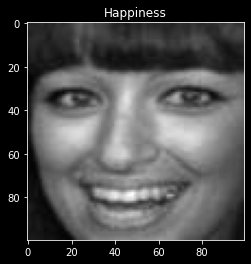

In [8]:
img, label = next(iter(CustomDataModule().setup("fit").train_dataloader().dataset))
# one_img = btx[0][0]
# one_label = btx[1][0]
# one_img.shape
# imshow(img)

plt.title(CLASS_LABELS[str(label)])
img =img.numpy()
if img.shape[0] == 3:
  img = img.transpose((1, 2, 0))
plt.imshow(img.squeeze(), cmap='gray' if img.shape[0] == 1 else None)

In [9]:

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 5
BATCH_SIZE = 32
# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()

from sklearn.metrics import confusion_matrix
import seaborn as sns

def train(model, learning_rate, train_dl, val_dl, epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    total_step = len(train_dl)
    for epoch in range(epochs):
        losses = []
        model.train()
        for images, labels in iter(train_dl):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            # print(images.shape, labels.shape)
            # Forward pass
            outputs = model(images)
            # print(outputs.shape)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            
        val_loss, val_acc = evaluate(model, val_dl, True)
            
        print ('Epoch [{}/{}], Training Loss: {:.4f}' 
                      .format(epoch+1, epochs, sum(losses) / len(losses)))
        print ('Epoch [{}/{}], Validation Loss: {:.4f}, Validation Accuracy: {:.4f}' 
                      .format(epoch+1, epochs, val_loss, val_acc))
      
def evaluate(model, val_dl, run_once=False):
    row = 10
    col = 6
    i = 1
    plt.figure(figsize=(25, 20))
    
    with torch.no_grad():
        model.eval()
        correct = 0
        total = 0
        rtn_preds = []
        rtn_labels = []
        rtn_losses = []
        for images, labels in val_dl:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # print(outputs[0])
            predicted = torch.argmax(outputs, dim=1).long()
            # print(predicted)
            total += labels.shape[0]
            correct += (predicted == labels).sum().item()

            rtn_preds.extend(predicted.detach().cpu().numpy())
            rtn_labels.extend(labels.detach().cpu().numpy())
            rtn_losses.append(loss.detach().cpu().item())
            
            # print(labels.shape)
            # print("Correct: ", labels.detach().cpu().numpy()[predicted.detach().cpu().numpy() != labels.detach().cpu().numpy()])
            # print("Incorrect: ", predicted.detach().cpu().numpy()[predicted.detach().cpu().numpy() != labels.detach().cpu().numpy()])
            # print(labels)
            # print(predicted)
            # print(predicted.detach().cpu().numpy()[predicted.detach().cpu().numpy() != labels.detach().cpu().numpy()])
            for ind, incorrect in enumerate(predicted):
                if predicted[ind] == labels[ind]:
                    continue
                
                subplot = plt.subplot(row, col, i, label=incorrect)
                subplot.imshow(images[ind].detach().cpu().numpy().squeeze(), cmap='gray')
                subplot.axis('off')
                subplot.set_title("Ind: " + str(ind) + " P: " + CLASS_LABELS[str(incorrect.item())] + ", A: " + CLASS_LABELS[str(labels[ind].cpu().item())])
                i += 1
            
            if run_once:
                break

        print('Accuracy of the network on the', total ,'validation images: {} %'.format(100 * correct / total))

    return np.array(rtn_losses).mean(), 100 * correct / total

def test(model, test_dl):
    fig = plt.figure(figsize=(25, 20))

    col = 8
    row = BATCH_SIZE/col
    rtn = {
        'id': [],
        'has_cactus': []
    }
    with torch.no_grad():
        model.eval()
        for idx, (images, labels, img_names) in enumerate(test_dl):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(images)
            # print(outputs[0])
            predicted = (outputs.reshape(-1) > 0.5).long()
            rtn['has_cactus'].extend(outputs.reshape(-1).detach().cpu().numpy())
            rtn['id'].extend(img_names)

            if idx % 10 == 0:
              for i, name in enumerate(img_names):
                subplot = plt.subplot(row, col, i + 1, label=name)
                subplot.imshow(read_image('test/' + name).reshape(3, 32, 32).T.numpy())
                subplot.axis('off')
                subplot.set_title(predicted[i])

    return rtn

def show_confusion_matrix(model, y_true, y_preds):
    print("Confusion Matrix of", type(model).__name__)
    mat = confusion_matrix(y_true, y_preds)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()

In [20]:
# 15 339 total images in label.txt
facial_model = FacialClassificationResNet18(in_channels=1)
data_module = CustomDataModule(
    train_transforms=transforms.Compose([
            transforms.ToPILImage(),
        #     transforms.RandomHorizontalFlip(0.5),
        #     transforms.RandomRotation(degrees=(-90, 90)),
        #     transforms.RandomVerticalFlip(0.5),
            transforms.ToTensor(),
            transforms.Normalize(0.5, 0.5)]),
    test_transforms=transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(0.5, 0.5)]),
)

data_module.setup("fit")

# train_dl = data_module.train_dataloader()
# val_dl = data_module.val_dataloader()
# test_dl = data_module.test_dataloader()

# train model
# trainer = pl.Trainer(accelerator='gpu' if DEVICE == 'cuda' else 'cpu', max_epochs=EPOCHS, auto_select_gpus=True, log_every_n_steps=10)
# trainer = pl.Trainer(accelerator='cpu', max_epochs=EPOCHS, auto_select_gpus=True, log_every_n_steps=10)
# trainer.fit(facial_model, datamodule=data_module)
# trainer.test(model=facial_model, datamodule=data_module)
# trainer.save_checkpoint("save.ckpt")

train(facial_model.to(DEVICE), learning_rate=0.001, epochs=20, train_dl=data_module.train_dataloader(), val_dl=data_module.val_dataloader())

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[32, 1, 100, 100] to have 3 channels, but got 1 channels instead

Accuracy of the network on the 50 validation images: 52.0 %


(1.6758369207382202, 52.0)

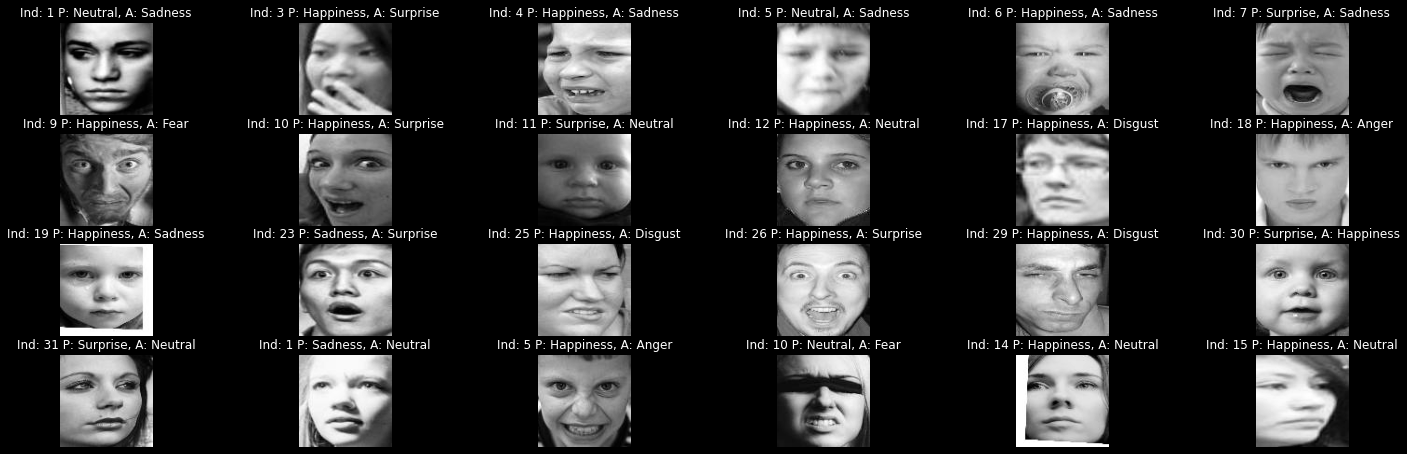

In [11]:
evaluate(facial_model, data_module.val_dataloader())

In [12]:
trainer.test(model=facial_model, datamodule=data_module)
# trainer.test(ckpt_path='save.ckpt', datamodule=data_module)

NameError: name 'trainer' is not defined